In [1]:
import random
import matplotlib.pyplot as plt

In [2]:
class Node:
    def __init__(self,num_actions):
        self.regretSum = [0.0] * num_actions
        self.strategy = [0.0] * num_actions
        self.strategySum  = [0.0] * num_actions
        self.num_actions = num_actions
        self.pPlayer = 0.0
        self.pOpponent = 0.0
        self.utility = 0.0
    
    #get liar die node current mixed strategy with regret-matching
    def getStrategy(self):
        normalizingSum = 0.0
        for a in range(self.num_actions):
            self.strategy[a] = max(self.regretSum[a],0)
            normalizingSum += self.strategy[a]
            
        for a in range(self.num_actions):
            if normalizingSum > 0:
                self.strategy[a] /= normalizingSum
            else:
                self.strategy[a] = 1.0 / self.num_actions
                
        for a in range(self.num_actions):
                self.strategySum[a] += self.pPlayer * self.strategy[a]
            
        return self.strategy
    
    #get liar die node average mixed strategy
    def getAverageStrategy(self):
        average_strategy = [0.0] * self.num_actions
        normalizingSum = sum(self.strategySum)
        for a in range(self.num_actions):
            if normalizingSum > 0:
                average_strategy[a] = self.strategySum[a] / normalizingSum
            else:
                average_strategy[a] = 1.0 / self.num_actions
        return average_strategy

In [3]:
def Initialisation(sides):
    responseNodes = [[Node(2) for _ in range(sides + 1)] for _ in range(sides)]
    for myClaim in range(sides + 1):
        for oppClaim in range(myClaim + 1,sides + 1):
            responseNodes[myClaim][oppClaim] = Node(
                1 if ((oppClaim == 0) or (oppClaim == sides))  
                else 2)
        claimNodes = [[Node(2) for _ in range(sides + 1)] for _ in range(sides)]
        for oppClaim in range(sides):
            for roll in range(1,sides + 1):
                claimNodes[oppClaim][roll] = Node(sides - oppClaim)
    return responseNodes, claimNodes

In [4]:
def train(iterations, record_interval=100, sides=6, DOUBT = 0, ACCEPT = 1, numActions = 2):
    responseNodes, claimNodes = Initialisation(sides)
    strategy_history = []
    
    for iter in range(iterations):
        #Initialize rolls with starting probabilities
        rollAfterAcceptingClaim = [random.randint(1, sides) for _ in range(sides)]
        
        claimNodes[0][rollAfterAcceptingClaim[0]].pPlayer = 1
        claimNodes[0][rollAfterAcceptingClaim[0]].pOpponent = 1
        
        #accumulate realization weights forward
        for oppClaim in range(sides + 1):
            #Visit response nodes forward
            if oppClaim > 0:
                for myClaim in range(oppClaim):
                    node = responseNodes[myClaim][oppClaim]
                    actionProb = node.getStrategy()
                    if oppClaim < sides:
                        nextNode = claimNodes[oppClaim][rollAfterAcceptingClaim[oppClaim]]
                        nextNode.pPlayer += actionProb[ACCEPT] * node.pPlayer
                        nextNode.pOpponent += node.pOpponent
                        
            #Visit claim node forward
            if oppClaim < sides:
                node = claimNodes[oppClaim][rollAfterAcceptingClaim[oppClaim]]
                actionProb = node.getStrategy()
                for myClaim in range(oppClaim+1,sides + 1):
                    nextClaimProb = actionProb[myClaim - oppClaim - 1]
                    if nextClaimProb > 0:
                        nextNode = responseNodes[oppClaim][myClaim]
                        nextNode.pPlayer += node.pOpponent
                        nextNode.pOpponent += nextClaimProb * node.pPlayer
                        
        #Backpropagate utilities, adjust regrets and strategies
        for oppClaim in range(sides, -1, -1):
            regret = [0.0] * sides
            #visit claim nodes backward
            if oppClaim < sides:
                node = claimNodes[oppClaim][rollAfterAcceptingClaim[oppClaim]]
                actionProb = node.strategy.copy() # copy?
                node.u = 0.0
                for myClaim in range(oppClaim+1,sides + 1):
                    actionIndex = myClaim - oppClaim - 1
                    nextNode = responseNodes[oppClaim][myClaim]
                    childUtil = -nextNode.u
                    regret[actionIndex] = childUtil
                    node.u += actionProb[actionIndex] * childUtil
                for a in range(len(actionProb)):
                    node.regretSum[a] += node.pOpponent * regret[a]
                node.pPlayer = node.pOpponent = 0
                
            #visit response nodes backward 
            if oppClaim > 0:
                for myClaim in range(oppClaim):
                    node = responseNodes[myClaim][oppClaim]
                    actionProb = node.strategy # copy?
                    node.u = 0.0
                    doubtUtil = 1 if oppClaim > rollAfterAcceptingClaim[myClaim] else -1
                    regret[DOUBT] = doubtUtil 
                    node.u += actionProb[DOUBT] * doubtUtil
                    if oppClaim < sides:
                        nextNode = claimNodes[oppClaim][rollAfterAcceptingClaim[oppClaim]]
                        accept_util = nextNode.u
                        regret[ACCEPT] = accept_util
                        node.u += actionProb[ACCEPT] * accept_util
                    for a in range(len(actionProb)):
                        regret[a] -= node.u
                        node.regretSum[a] += node.pOpponent * regret[a]
                    node.pPlayer = node.pOpponent = 0
        #reset strategy sums after half of training
        if iter == iterations //2:
            for nodes in responseNodes:
                for node in nodes:
                        for a in range(len(node.strategySum)):
                            node.strategySum[a] = 0
            for nodes in claimNodes:
                for node in nodes:
                        for a in range(len(node.strategySum)):
                            node.strategySum[a] = 0
                            
        # Record strategies at specified intervals
        if iter % record_interval == 0 or iter == iterations - 1:
            snapshot = {}
            for my_claim in range(sides + 1):
                for opp_claim in range(my_claim + 1, sides + 1):
                    snapshot[(my_claim, opp_claim)] = responseNodes[my_claim][opp_claim].getAverageStrategy()
            strategy_history.append((iter, snapshot))
            
            
    #Print strategy
    for initialRoll in range(1,sides+1):
        print('Initial claim policy with role {0}'.format(initialRoll))
        # for prob in claimNodes[0][initialRoll].getAverageStrategy():
        print([f'{prob:0.2f}' for prob in claimNodes[0][initialRoll].getAverageStrategy()])
    
    print('\nOld Claim\tNew Claim\tActionProbabilities')
    for myClaim in range(sides + 1):
        for oppClaim in range(myClaim + 1, sides + 1):
            print(f'\t{myClaim}\t{oppClaim}\t\t{responseNodes[myClaim][oppClaim].getAverageStrategy()}')

    print('\nOld Claim\tRoll\tActionProbabilities')
    for oppClaim in range(sides):
        for roll in range(1,sides+1):
            # print('{0}\t\t{1}\t{2}'.format(oppClaim,roll,str(claimNodes[oppClaim][roll].getAverageStrategy())))
            print(f'{oppClaim}\t\t{roll}\t{claimNodes[oppClaim][roll].getAverageStrategy()}')

    return responseNodes, claimNodes, strategy_history

In [5]:
R, C, SH = train(1000000)

Initial claim policy with role 1
['0.04', '0.04', '0.28', '0.55', '0.04', '0.04']
Initial claim policy with role 2
['0.09', '0.09', '0.46', '0.18', '0.09', '0.09']
Initial claim policy with role 3
['0.00', '0.00', '0.96', '0.04', '0.00', '0.00']
Initial claim policy with role 4
['0.00', '0.00', '0.01', '0.99', '0.00', '0.00']
Initial claim policy with role 5
['0.00', '0.00', '0.00', '0.34', '0.66', '0.00']
Initial claim policy with role 6
['0.00', '0.00', '0.00', '0.20', '0.39', '0.40']

Old Claim	New Claim	ActionProbabilities
	0	1		[0.0, 1.0]
	0	2		[0.0, 1.0]
	0	3		[0.0, 1.0]
	0	4		[0.24492913460284269, 0.7550708653971573]
	0	5		[0.8197553388695431, 0.18024466113045687]
	0	6		[1.0]
	1	2		[0.0, 1.0]
	1	3		[0.0, 1.0]
	1	4		[0.23007029960824235, 0.7699297003917576]
	1	5		[1.0, 0.0]
	1	6		[1.0]
	2	3		[0.0, 1.0]
	2	4		[0.2578016769903894, 0.7421983230096106]
	2	5		[1.0, 0.0]
	2	6		[1.0]
	3	4		[1.0, 0.0]
	3	5		[1.0, 0.0]
	3	6		[1.0]
	4	5		[1.0, 0.0]
	4	6		[1.0]
	5	6		[1.0]

Old Claim	Roll	A

# Plot

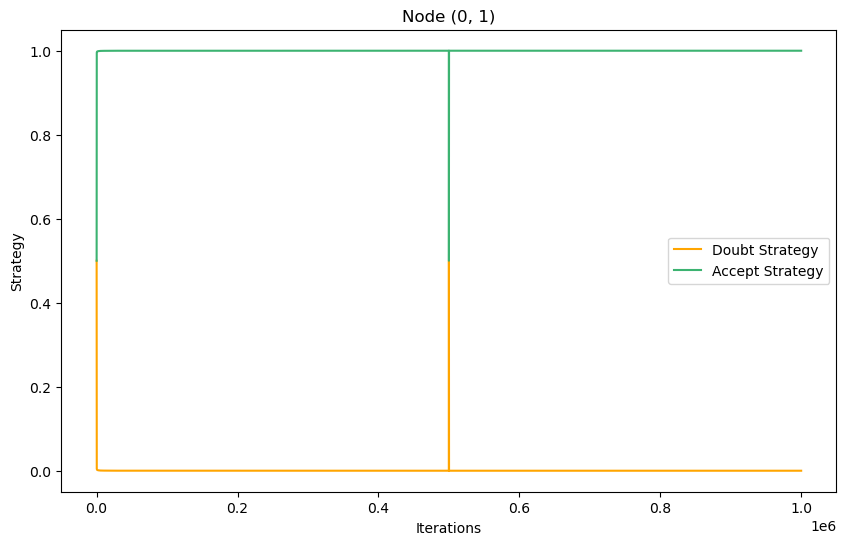

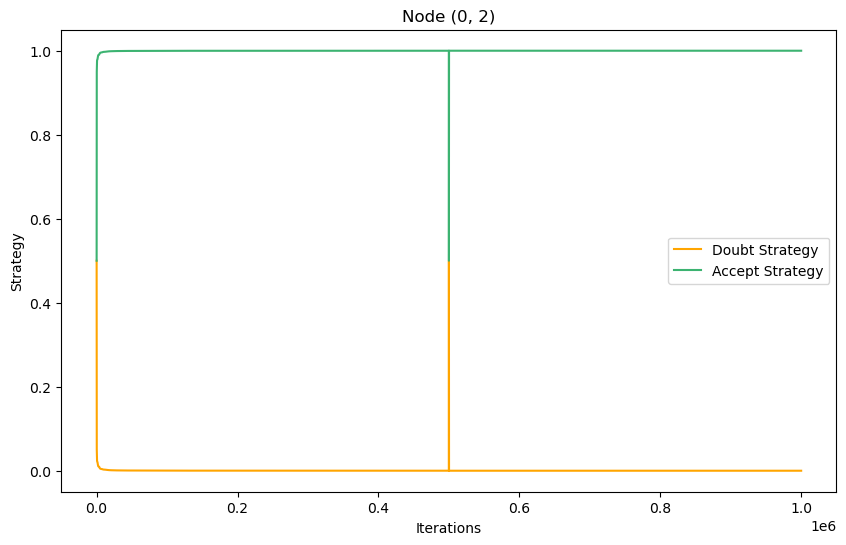

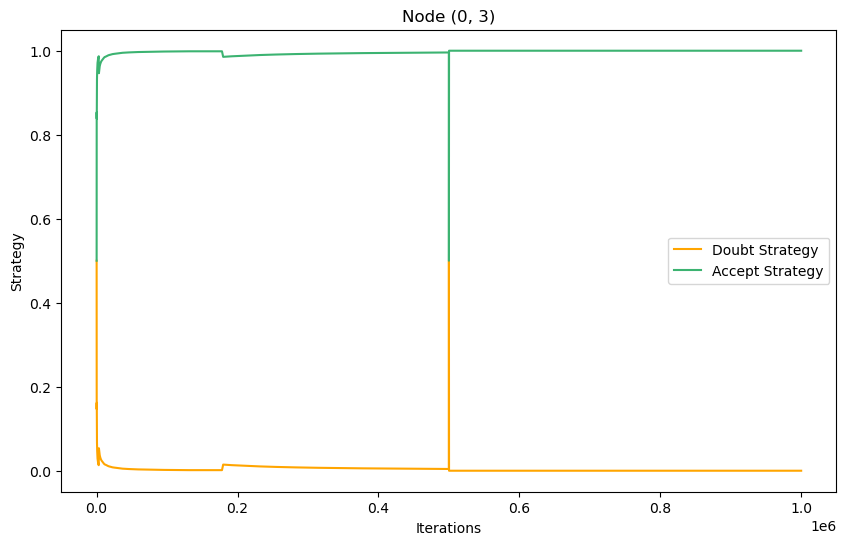

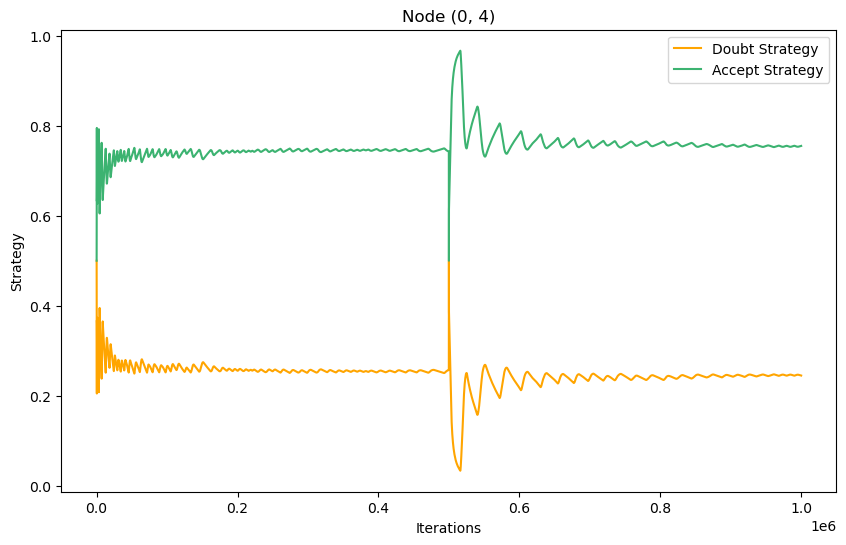

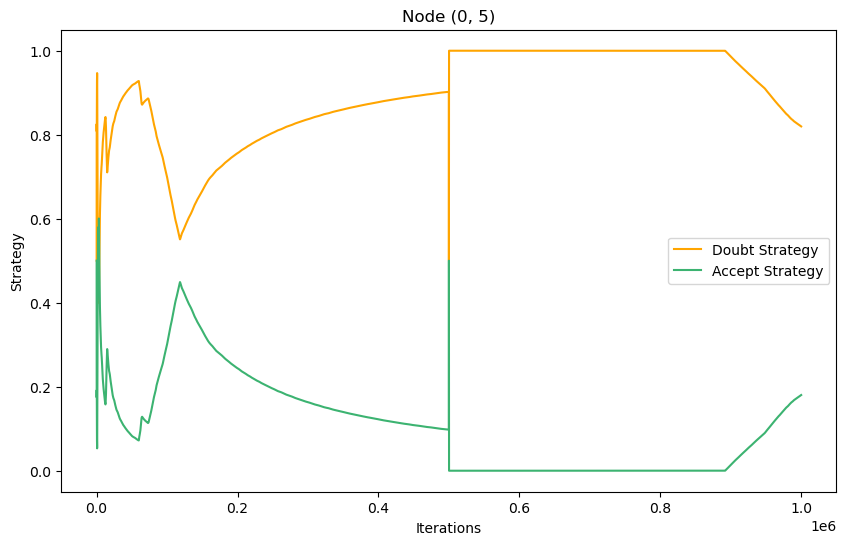

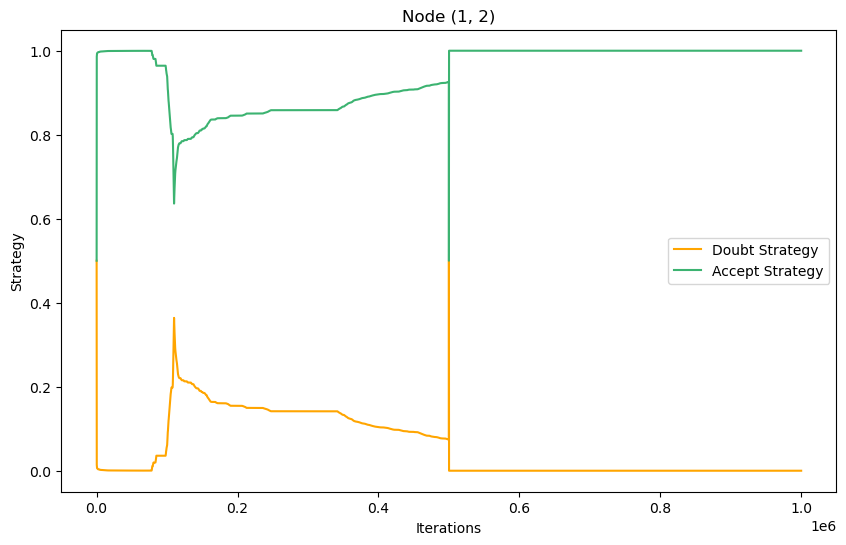

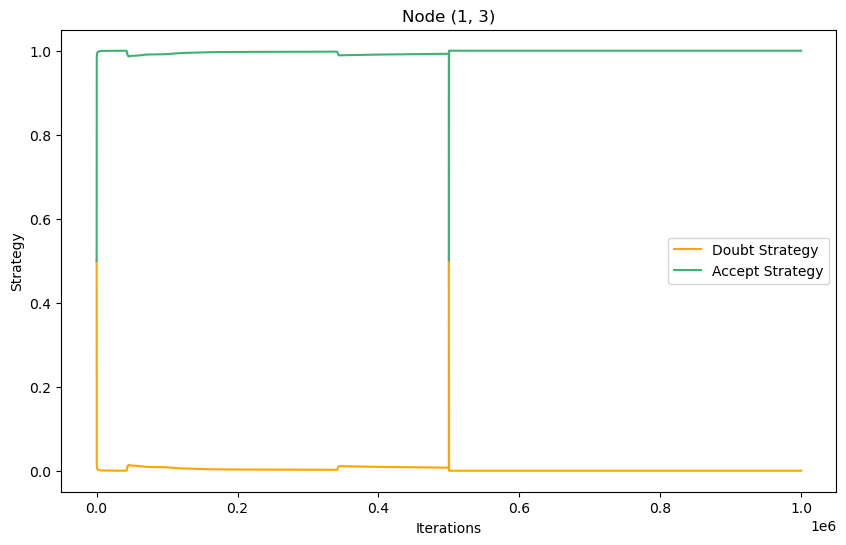

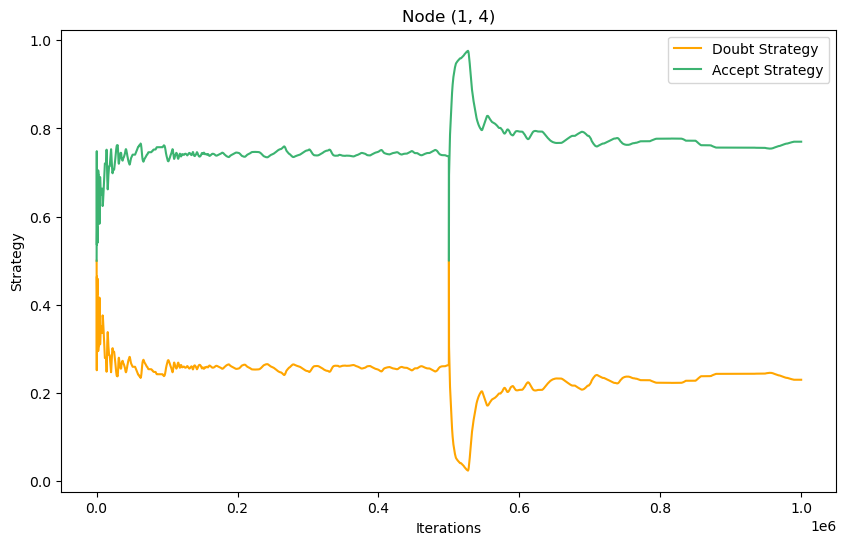

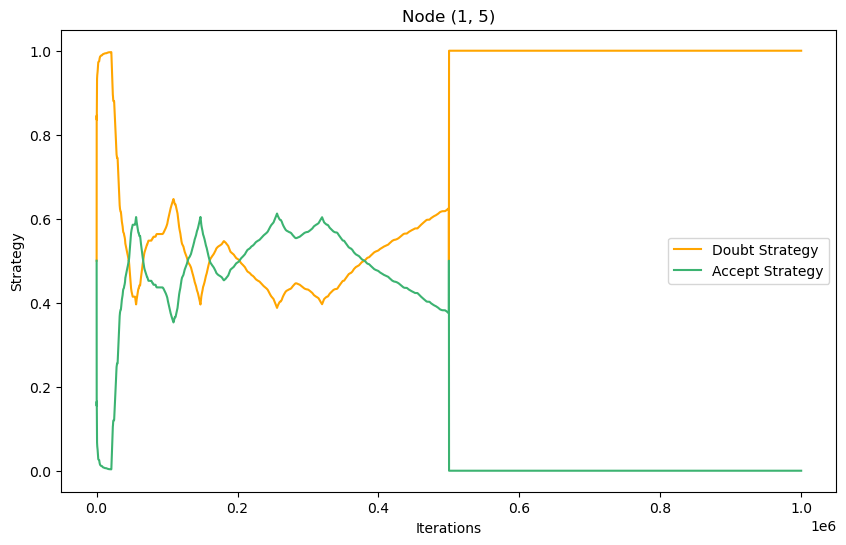

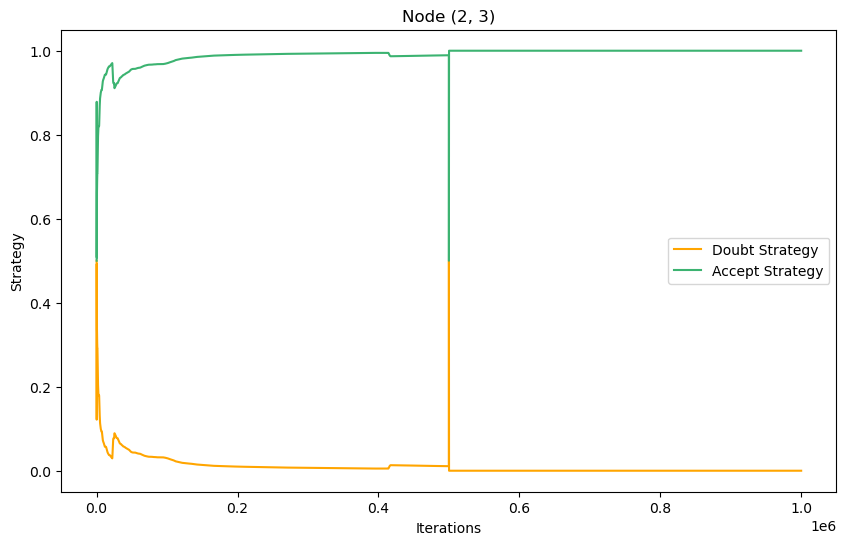

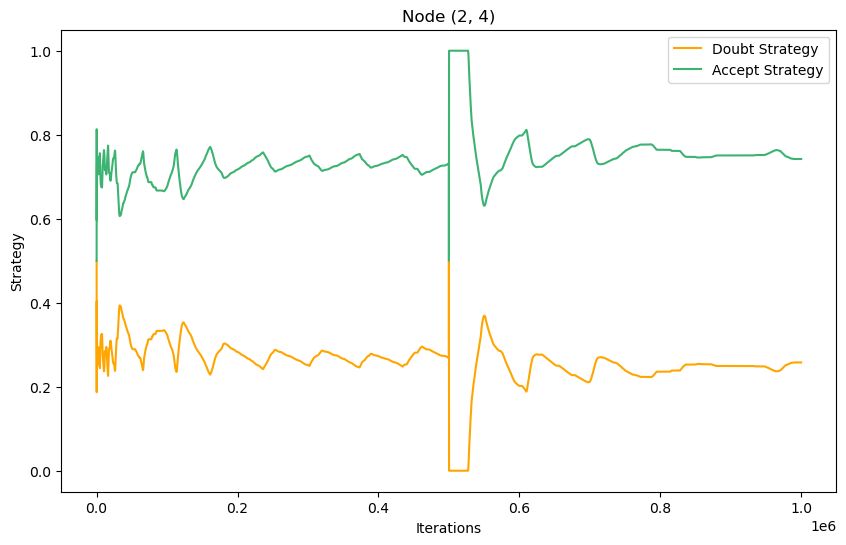

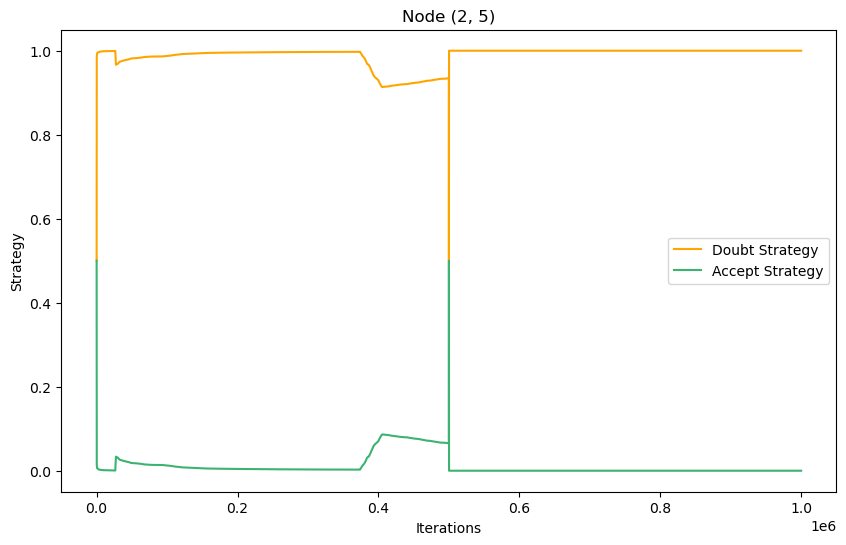

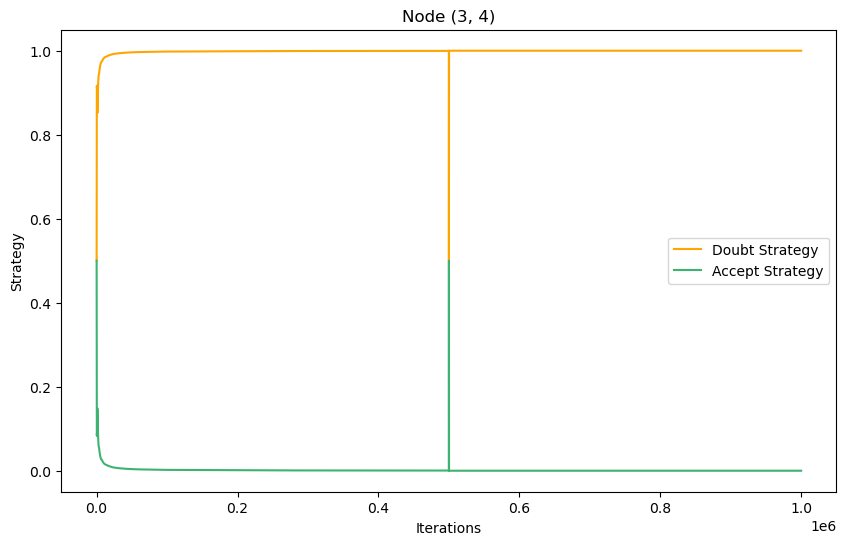

KeyboardInterrupt: 

In [7]:
def plotting(strategy_history, sides):
    claims = [z for z in range(7)]
    for j in claims:
        possoible_claim = [y for y in range(j+1, 6)]
        if j == 5:
            strategies_doubt = [record[1][(j, 6)][0] for record in strategy_history]
            plt.figure(figsize=(10, 6))
            plt.plot(iterations, strategies_doubt, label='Doubt Strategy',color='mediumseagreen')
            plt.xlabel('Iterations')
            plt.ylabel('Strategy')
            plt.title(f'Strategy Convergence for Node ({j}, {6})')
            plt.legend()
            
        for i in possoible_claim:
            # Extracting strategy values for plotting
            iterations = [record[0] for record in strategy_history]
            strategies_doubt = [record[1][(j, i)][0] for record in strategy_history]  # DOUBT strategy
            strategies_accept = [record[1][(j, i)][1] for record in strategy_history]  # ACCEPT strategy
            
            plt.figure(figsize=(10, 6))
            plt.plot(iterations, strategies_doubt, label='Doubt Strategy',color='orange')
            plt.plot(iterations, strategies_accept, label='Accept Strategy',color='mediumseagreen')
            plt.xlabel('Iterations')
            plt.ylabel('Strategy')
            plt.title(f'Node ({j}, {i})')
            plt.legend()
            # plt.grid(True)
            plt.show()

plotting(SH, 6)

# Rewrite

In [119]:
class Node:
    def __init__(self, num_actions):
        self.num_actions = num_actions
        self.regret_sum = [0.0] * num_actions
        self.strategy = [0.0] * num_actions
        self.strategy_sum = [0.0] * num_actions
        self.p_player = 0.0
        self.p_opponent = 0.0
        self.u = 0.0  

    def get_strategy(self):
        normalizing_sum = sum(max(self.regret_sum[a], 0) for a in range(len(self.strategy)))
        for a in range(len(self.strategy)):
            if normalizing_sum > 0:
                self.strategy[a] /= normalizing_sum
            else:
                self.strategy[a] = 1.0 / len(self.strategy)
        for a in range(len(self.strategy)):
            self.strategy_sum[a] += self.p_player * self.strategy[a]
        return self.strategy

    def get_average_strategy(self):
        normalizing_sum = sum(self.strategy_sum)
        return [s / normalizing_sum if normalizing_sum > 0 else 1.0 / len(self.strategy_sum) 
                for s in self.strategy_sum]

In [120]:
DOUBT = 0
ACCEPT = 1
num_actions = 2
sides = 6  # number of sides of a die
regret_sum = [0.0] * sides
strategy = [0.0] * sides
strategy_sum = [0.0] * sides
p_player = 0.0
p_opponent = 0.0
response_nodes = [[Node(num_actions) for _ in range(sides + 1)] for _ in range(sides + 1)]
claim_nodes = [[Node(num_actions) for _ in range(sides + 1)] for _ in range(sides)]

In [121]:
def liar_die_trainer(sides):
    response_nodes = [[Node(1 if (opp_claim == 0 or opp_claim == 2) else 2) for opp_claim in range(sides + 1)] 
                      for my_claim in range(sides + 1)]

    for my_claim in range(sides + 1):
        for opp_claim in range(my_claim + 1, sides + 1):
            response_nodes[my_claim][opp_claim] = Node(1 if (opp_claim == 0 or opp_claim == sides) else 2)

    claim_nodes = [[Node(sides - opp_claim) for roll in range(1, sides + 1)] for opp_claim in range(sides)]

    return response_nodes, claim_nodes

In [122]:
def train(iterations):
    regret = [0.0] * sides
    roll_after_accepting_claim = [0] * sides

    for _ in range(iterations):
        # Initialize rolls with starting probabilities
        for i in range(len(roll_after_accepting_claim)):
            roll_after_accepting_claim[i] = random.randint(0, 5)

        claim_nodes[0][roll_after_accepting_claim[0]] = Node(sides)
        claim_nodes[0][roll_after_accepting_claim[0]].p_player = 1
        claim_nodes[0][roll_after_accepting_claim[0]].p_opponent = 1

        # Accumulate realization weights forward
        for opp_claim in range(sides + 1):
            # Visit response nodes forward
            if opp_claim > 0:
                for my_claim in range(opp_claim):
                    node = response_nodes[my_claim][opp_claim]
                    action_prob = node.get_strategy()

                    if opp_claim < sides:
                        next_node = claim_nodes[opp_claim][roll_after_accepting_claim[opp_claim]]
                        next_claim_prob = action_prob[DOUBT]
                        next_node.p_player += next_claim_prob * node.p_player
                        next_node.p_opponent += node.p_opponent

            # Visit claim node forward
            if opp_claim < sides:
                node = claim_nodes[opp_claim][roll_after_accepting_claim[opp_claim]]
                action_prob = node.get_strategy()

                for my_claim in range(opp_claim + 1, sides + 1):
                    next_claim_prob_index = my_claim - opp_claim - 1
                    # print(f"Debug: next_claim_prob_index={next_claim_prob_index}, action_prob={action_prob}")
                    next_claim_prob = action_prob[next_claim_prob_index]

                    if next_claim_prob > 0:
                        next_node = response_nodes[opp_claim][my_claim]
                        next_node.p_player += node.p_opponent
                        next_node.p_opponent += next_claim_prob * node.p_player

        # Backpropagate utilities, adjust regrets, and strategies
        for opp_claim in range(sides - 1, -1, -1):
            # Visit claim nodes backward
            if opp_claim < sides:
                node = claim_nodes[opp_claim][roll_after_accepting_claim[opp_claim]]
                action_prob = node.strategy
                node.u = 0.0

                for my_claim in range(opp_claim + 1, sides + 1):
                    action_index = my_claim - opp_claim - 1

                    if 0 <= action_index < len(action_prob):  # Ensure the index is valid
                        next_node = response_nodes[opp_claim][my_claim]
                        child_util = -next_node.u
                        regret[action_index] = child_util
                        node.u += action_prob[action_index] * child_util

                for a in range(len(action_prob)):
                    regret[a] -= node.u
                    node.regret_sum[a] += node.p_opponent * regret[a]

                node.p_player = node.p_opponent = 0

            # Visit response nodes backward
            if opp_claim > 0:
                for my_claim in range(opp_claim):
                    node = response_nodes[my_claim][opp_claim]
                    action_prob = node.strategy
                    node.u = 0.0
                    doubt_util = 1 if opp_claim > roll_after_accepting_claim[my_claim] else -1
                    regret[DOUBT] = doubt_util
                    node.u += action_prob[DOUBT] * doubt_util

                    if opp_claim < sides:
                        next_node = claim_nodes[opp_claim][roll_after_accepting_claim[opp_claim]]
                        regret[ACCEPT] = next_node.u

                        # Use the correct index instead of ACCEPT
                        action_index = min(ACCEPT, len(action_prob) - 1)  
                        node.u += action_prob[action_index] * next_node.u

                    for a in range(len(action_prob)):
                        regret[a] -= node.u
                        node.regret_sum[a] += node.p_opponent * regret[a]

                    node.p_player = node.p_opponent = 0


        # Reset strategy sums after half of training
        if _ == (iterations / 2):
            for nodes in response_nodes:
                for node in nodes:
                    if node is not None:
                        node.strategy_sum = [0] * len(node.strategy_sum)

            for nodes in claim_nodes:
                for node in nodes:
                    if node is not None:
                        node.strategy_sum = [0] * len(node.strategy_sum)
                        
    # print
    for initialRoll in range(1, sides + 1):
        print('Initial claim policy with role {0}'.format(initialRoll))
        for prob in claim_nodes[0][initialRoll - 1].get_average_strategy():
            print('{0:2.2f}'.format(prob))

    print('\nOld Claim\tNew Claim\tAction Probabilities')
    for myClaim in range(sides + 1):
        for oppClaim in range(myClaim + 1, sides + 1):
            print('\t{0}\t{1}\t\t{2}'.format(myClaim, oppClaim, str(response_nodes[myClaim][oppClaim].get_average_strategy())))

    print('\nOld Claim\tRoll\tAction Probabilities')
    for oppClaim in range(sides):
        for roll in range(1, oppClaim + 2):
            print('{0}\t\t{1}\t{2}'.format(oppClaim, roll, str(claim_nodes[oppClaim][roll - 1].get_average_strategy())))


In [123]:
# Constants
DOUBT, ACCEPT = 0, 1
SIDES = 6
ITERATIONS = 10000

# Main training
response_nodes, claim_nodes = liar_die_trainer(SIDES)
train(ITERATIONS)

Initial claim policy with role 1
0.17
0.17
0.17
0.17
0.17
0.17
Initial claim policy with role 2
0.17
0.17
0.17
0.17
0.17
0.17
Initial claim policy with role 3
0.17
0.17
0.17
0.17
0.17
0.17
Initial claim policy with role 4
0.17
0.17
0.17
0.17
0.17
0.17
Initial claim policy with role 5
0.17
0.17
0.17
0.17
0.17
0.17
Initial claim policy with role 6
0.17
0.17
0.17
0.17
0.17
0.17

Old Claim	New Claim	Action Probabilities
	0	1		[0.5, 0.5]
	0	2		[0.5, 0.5]
	0	3		[0.5, 0.5]
	0	4		[0.5, 0.5]
	0	5		[0.5, 0.5]
	0	6		[1.0]
	1	2		[0.5, 0.5]
	1	3		[0.5, 0.5]
	1	4		[0.5, 0.5]
	1	5		[0.5, 0.5]
	1	6		[1.0]
	2	3		[0.5, 0.5]
	2	4		[0.5, 0.5]
	2	5		[0.5, 0.5]
	2	6		[1.0]
	3	4		[0.5, 0.5]
	3	5		[0.5, 0.5]
	3	6		[1.0]
	4	5		[0.5, 0.5]
	4	6		[1.0]
	5	6		[1.0]

Old Claim	Roll	Action Probabilities
0		1	[0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669]
1		1	[0.2, 0.2, 0.2, 0.2, 0.2]
1		2	[0.2, 0.2, 0.2, 0.2, 0.2]
2		1	[0.25, 0.25, 0.25